# Statistical methods in AI

## Assignment 2

### Problem 1:
### Principle Component Analysis

In [1]:
# Installing Pillow Libraries
!pip install scikit-learn matplotlib Pillow

In [5]:
import numpy as np
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
import heapq
from tqdm import tqdm
import pickle
import pandas as pd
from sklearn import model_selection, neighbors, metrics

ImportError: this version of pandas is incompatible with numpy < 1.20.3
your numpy version is 1.20.2.
Please upgrade numpy to >= 1.20.3 to use this pandas version

In [6]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [7]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [8]:
dirpath = 'IIIT-CFW/'
X,y = load_data(dirpath)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


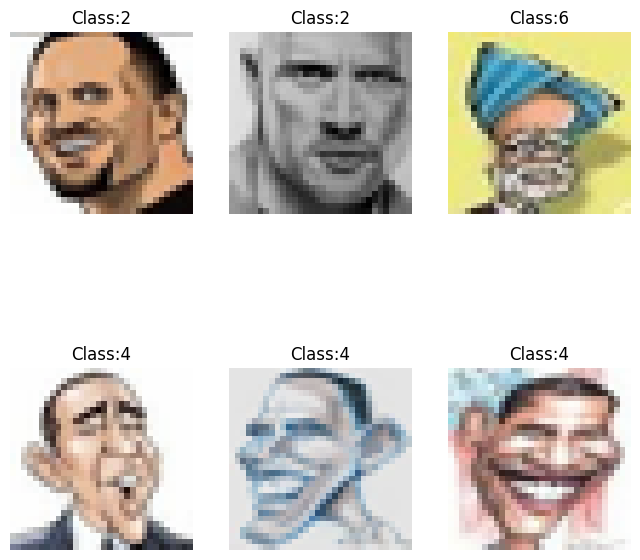

In [9]:
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row=2,col=3)

Above code is the given script to extract the important features from the images. Now we will begin by implementing a class to compute the PCA of our data.

In [10]:
class PCA:
    def __init__(self):
        self.exp_var = None

    def fit_model(self, X, n_pca):
        X_mean = np.mean(X, axis = 0) # Centering the data 
        X = X - X_mean

        covariance = np.cov(X.T) # Computing the Covariance marix of the data

        eig_values, eig_vectors = np.linalg.eig(covariance) # Computing the eigenvectors and eigenvalues

        index = np.argsort(eig_values)[::-1] # Getting the indexes of the the eigenvalues sorted in the decreasing order
        eig_vectors = eig_vectors[index]

        components = eig_vectors[:, :n_pca] # Obtaining the top n_pca vectors on which the data needs to be projected

        eig_values = eig_values[index]
        self.exp_var = [i/sum(eig_values) for i in eig_values] # Computing the explained variance ratio for the individaul eigen vectors
        
        return np.dot(X, components)

Now we can verify the working of our class with the given data.

In [12]:
df = pd.read_feather('word_enc_df.feather')

# Write to CSV
df.to_csv('word_embedding.csv', index=False)

NameError: name 'pd' is not defined

In [7]:
X = np.reshape(X, (672, -1)) # Reshaping to obtain a matrix
model = PCA()
X_reduced = model.fit_model(X, 2)

print(X_reduced.shape) # Prints new shape of the data after reduction. should obtain (672, n_pca)

(672, 2)


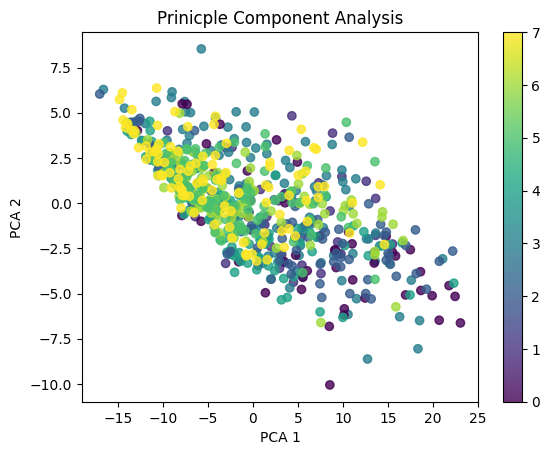

In [9]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c = y, alpha = 0.8)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Prinicple Component Analysis')
plt.colorbar()
plt.show()

The above plot is for the reduced dimetionality of our data coloured according to their labels. Now let us plot the cumulative explained variance vs the number of principle components.

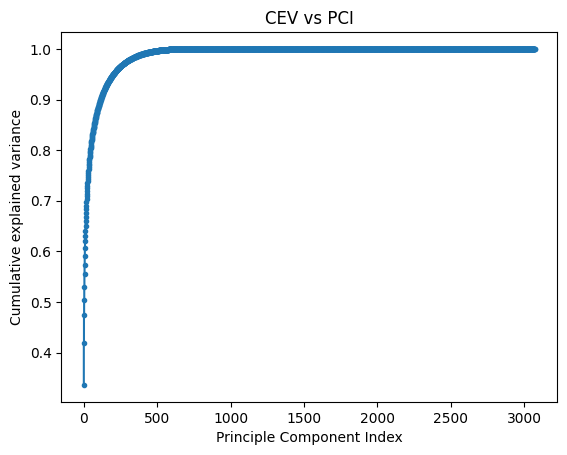

In [11]:
cumulative_exp_var = np.cumsum(model.exp_var) # Getting the sum of previous exp_var
plt.step(range(len(cumulative_exp_var)) ,cumulative_exp_var, '.-')
plt.xlabel('Principle Component Index')
plt.ylabel('Cumulative explained variance')
plt.title('CEV vs PCI')
plt.show()

As we can see that the cumulative explained varianc is almost constant for higher values of PCI, which means the explained variance at those indexes are very less. Conversely at the lower indexes, the increase is high meaning that the explained variance at those points are very high.

Now let us use our PCA functions to reduce the dimensionality of the pictionary datasets from our previous assignment. As we can see in the above curve, it starts to turn at about 400 components, so we will observe the accuracy of the model at k = 400.

In [13]:
np.random.seed(42)
with open('data.npy', 'rb') as f:
    data = pickle.load(f)

model = PCA()

df = pd.DataFrame(data)
df.columns = ['Index','ResNet','VIT','Class','Time']

X_p = np.vstack(df['VIT']) # Get the Inputs and outputs
Y_p = df['Class']

print('METRICS used are ENCODER: VIT, k:9, METRIC:Euclidean')
print('Original Shape pre-PCA:', X_p.shape)

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_p, Y_p, test_size = 0.2) 

sk_model = neighbors.KNeighborsClassifier(n_neighbors = 9,metric='euclidean') # Creating and training the model.
sk_model.fit(X_train, Y_train)

y_pred = sk_model.predict(X_test)

sk_accuracy = [metrics.accuracy_score(Y_test, y_pred)]
print('Accuracy:', sk_accuracy)

X_reduced = model.fit_model(X_p, 400)
print(f'Shape after post-PCA: {X_reduced.shape}')


X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_reduced, Y_p, test_size = 0.2)
sk_model = neighbors.KNeighborsClassifier(n_neighbors = 9,metric='euclidean') # Creating and training the model.
sk_model.fit(X_train, Y_train)

y_pred = sk_model.predict(X_test)

print(f'Accuracy: {metrics.accuracy_score(Y_test, y_pred)}')

METRICS used are ENCODER: VIT, k:9, METRIC:Euclidean
Original Shape pre-PCA: (1500, 512)
Accuracy: [0.22]
Shape after post-PCA: (1500, 400)
Accuracy: 0.25


Above is the accuracy for pre-reduction of the data. As we can see that the accuracy for the post reduction of the datset is greater. Now let us observe the accuracies for reduction of dimensions from 1 to n.

In [11]:
np.random.seed(42) # To keep the split constant at every iteration
accuracy_red = [] # Set of accuracies for reduced dimensions

for i in range(1, X_p.shape[1]):
    X_reduced = model.fit_model(X_p, i) # Reducing it to its desired dimensions 
    print('-------------------------')
    print('Shape of reduced data:', X_reduced.shape)
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_reduced, Y_p, test_size = 0.2)

    sk_model = neighbors.KNeighborsClassifier(n_neighbors = 9,metric='euclidean') # Creating and training the model.
    sk_model.fit(X_train, Y_train)

    y_pred = sk_model.predict(X_test)

    print('-------------------------')
    accuracy_red.append(metrics.accuracy_score(Y_test, y_pred))
    print('-------------------------')
    print(f'Accuracy for {i}th dimension reduction :', accuracy_red[-1]) 
    print(f'Precision for {i}th dimension eduction :', metrics.precision_score(Y_test, y_pred, average = 'macro', zero_division = 0))
    print(f'Recall for {i}th dimension eduction :', metrics.recall_score(Y_test, y_pred, average = 'macro', zero_division = 0))
    print(f'F1 score for {i}th dimension eduction :', metrics.f1_score(Y_test, y_pred, average = 'macro', zero_division = 0))
      

-------------------------
Shape of reduced data: (1500, 1)
-------------------------
-------------------------
Accuracy for 1th dimension reduction : 0.006666666666666667
Precision for 1th dimension eduction : 0.0029082774049217002
Recall for 1th dimension eduction : 0.003914988814317673
F1 score for 1th dimension eduction : 0.0031959092361776922
-------------------------
Shape of reduced data: (1500, 2)
-------------------------
-------------------------
Accuracy for 2th dimension reduction : 0.02
Precision for 2th dimension eduction : 0.016210045662100457
Recall for 2th dimension eduction : 0.02289628180039139
F1 score for 2th dimension eduction : 0.018026151930261518
-------------------------
Shape of reduced data: (1500, 3)
-------------------------
-------------------------
Accuracy for 3th dimension reduction : 0.043333333333333335
Precision for 3th dimension eduction : 0.02365390600684718
Recall for 3th dimension eduction : 0.032352941176470584
F1 score for 3th dimension eductio

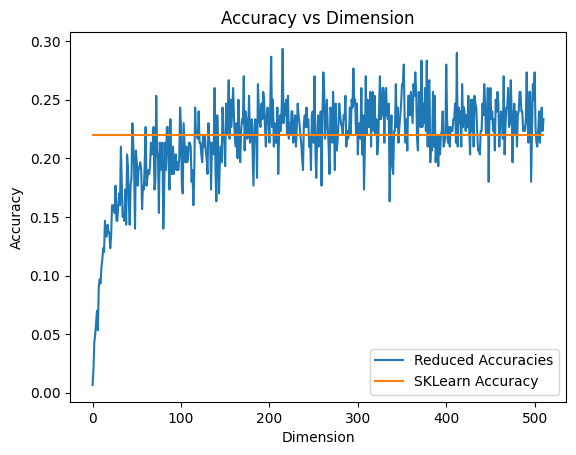

In [12]:
# Plotting the Accuracy vs dimensions graph

plt.plot(range(len(accuracy_red)), accuracy_red, '-', label = 'Reduced Accuracies')
plt.plot(range(len(accuracy_red)), sk_accuracy*len(accuracy_red), label = 'SKLearn Accuracy')
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Dimension')
plt.legend()
plt.show()

We can observe that at around 200 dimensions, the accuracy given by the classifier drops as for when it is more than 200, the accuracy is more than the original accuracy most of the time. This is because reducing dimensions can get rid of unnesecarry dimensions. This is similar to what we do in feature selection.

Let us now implement the same thing on the IIIT-CFW dataset. Here also, let us observe the pre and post reduction at dimensions = 400

In [16]:
print('METRICS used are ENCODER: VIT, k:9, METRIC:Euclidean')
print('Original Shape:', X.shape)

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, y, test_size = 0.2) 

sk_model = neighbors.KNeighborsClassifier(n_neighbors = 9,metric='euclidean') # Creating and training the model.
sk_model.fit(np.real(X_train), Y_train)

y_pred = sk_model.predict(np.real(X_test))

sk_accuracy_face = [metrics.accuracy_score(Y_test, y_pred)]
print('Accuracy:', sk_accuracy_face)

X_reduced = model.fit_model(X, 400)
print(f'Shape after post-PCA: {X_reduced.shape}')


X_train, X_test, Y_train, Y_test = model_selection.train_test_split(np.real(X_reduced), y, test_size = 0.2)
sk_model = neighbors.KNeighborsClassifier(n_neighbors = 9,metric='euclidean') # Creating and training the model.
sk_model.fit(X_train, Y_train)

y_pred = sk_model.predict(X_test)

print(f'Accuracy: {metrics.accuracy_score(Y_test, y_pred)}')

METRICS used are ENCODER: VIT, k:9, METRIC:Euclidean
Original Shape: (672, 3072)
Accuracy: [0.34074074074074073]
Shape after post-PCA: (672, 400)
Accuracy: 0.4666666666666667


We can see how well the model does post reduction of the data. Now let us see the accuracies post reduction to all possible dimensions.

In [14]:
accuracy_red_face = [] # Set of accuracies for reduced dimensions
model = PCA() 

for i in range(1, X.shape[1], 50):
    X_reduced = model.fit_model(X, i) # Reducing it to its desired dimensions 
    print('---------------------------')
    print('Shape of reduced data:', X_reduced.shape)
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_reduced, y, test_size = 0.2)

    sk_model = neighbors.KNeighborsClassifier(n_neighbors = 9,metric='euclidean') # Creating and training the model.
    sk_model.fit(np.real(X_train), Y_train)

    y_pred = sk_model.predict(np.real(X_test))

    accuracy_red_face.append(metrics.accuracy_score(Y_test, y_pred))
    print('-------------------------')
    print(f'Accuracy for {i}th dimension reduction :', accuracy_red[-1]) 
    print(f'Precision for {i}th dimension eduction :', metrics.precision_score(Y_test, y_pred, average = 'macro', zero_division = 0))
    print(f'Recall for {i}th dimension eduction :', metrics.recall_score(Y_test, y_pred, average = 'macro', zero_division = 0))
    print(f'F1 score for {i}th dimension eduction :', metrics.f1_score(Y_test, y_pred, average = 'macro', zero_division = 0))
      

---------------------------
Shape of reduced data: (672, 1)
-------------------------
Accuracy for 1th dimension reduction : 0.23333333333333334
Precision for 1th dimension eduction : 0.21664424875594784
Recall for 1th dimension eduction : 0.21488487358052574
F1 score for 1th dimension eduction : 0.20786900632856986
---------------------------
Shape of reduced data: (672, 51)
-------------------------
Accuracy for 51th dimension reduction : 0.23333333333333334
Precision for 51th dimension eduction : 0.3264756944444444
Recall for 51th dimension eduction : 0.3005855119825708
F1 score for 51th dimension eduction : 0.27088905926115225
---------------------------
Shape of reduced data: (672, 101)
-------------------------
Accuracy for 101th dimension reduction : 0.23333333333333334
Precision for 101th dimension eduction : 0.44215527119938886
Recall for 101th dimension eduction : 0.38924233661075763
F1 score for 101th dimension eduction : 0.40339418768572904
---------------------------
Shape

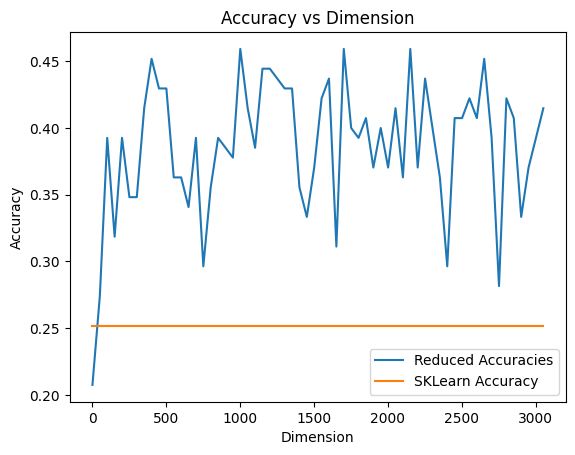

In [17]:

plt.plot(range(1, X.shape[1], 50), accuracy_red_face, '-', label = 'Reduced Accuracies')
plt.plot(range(1, X.shape[1], 50), sk_accuracy_face*len(accuracy_red_face), label = 'SKLearn Accuracy')
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Dimension')
plt.legend()
plt.show()

As we can see, reducing the Dimensions gives us better classification results. This can be reasoned as an image contains alot of unnecessary information and reducing the dimensions only captures the relevant features and the more needed pixels to make the classification which gives better classification results.

Now we are given 2 other datasets on which we are supposed to perform PCA. These datasets are attributes of a drawer and a guesser in a game of pitionary. They have a couple attributes which we cannot plot inorder to visulise, hece we will perform PCA to reduce its dimensionality to 2 and visualise the attributes in a 2 dimensional space. First let us perform this for the Drawer.

In [6]:
pip install openpyxl # installing openpyxl

     |████████████████████████████████| 249 kB 326 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [17]:
data = pd.read_excel('drawer_attributes.xlsx')
drawer_data = data.drop('d_drawer', axis = 1)
print(drawer_data.head())

   d_area_median  d_stroke_freq_median  d_rangestroketime_median  \
0       0.000000              0.000000                     0.000   
1   82306.749763              0.578802                    21.660   
2   60929.328432              0.239168                    25.087   
3  119037.637976              0.402533                    54.162   
4       0.000000              0.000000                     0.000   

   d_firststroketime_median  d_laststroketime_median  d_pcgamestup  \
0                     0.000                    0.000          0.00   
1                     3.512                   26.815          0.00   
2                     1.368                   26.455          1.00   
3                     2.459                   56.621          0.75   
4                     0.000                    0.000          0.00   

   d_pcgamestdown  d_pcgameserasehighlight  
0             0.0                 0.000000  
1             0.0                 0.777778  
2             1.0                 1

In [18]:
model = PCA()
drawer_reduced = model.fit_model(drawer_data, 2)
print(f'Original shape: {drawer_data.shape}')
print(f'Reduced shape: {drawer_reduced.shape}')

Original shape: (100, 8)
Reduced shape: (100, 2)


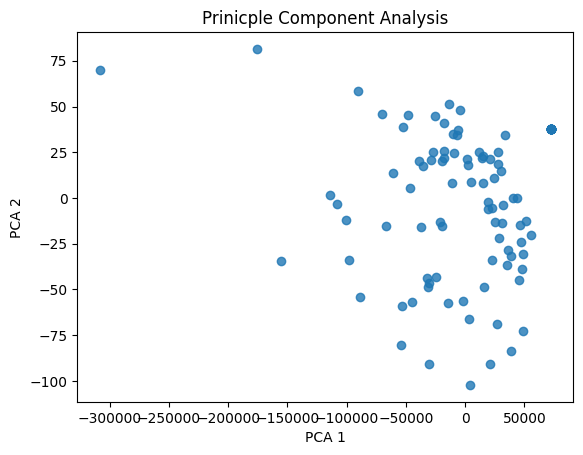

In [28]:
plt.scatter(drawer_reduced[:, 0], drawer_reduced[:, 1], alpha = 0.8)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Prinicple Component Analysis')
plt.show()

 We can see mos of the data concentrating to the centre, while there a couple outliers which exist.
 Now we will perform PCA for the guesser dataset.

In [29]:
data = pd.read_excel('guesser_attributes.xlsx')
guesser_data = data.drop('g_guesser', axis = 1)
print(guesser_data.head())

   g_noofmessage_median  g_firstmessagetime_median  g_lastmessagetime_median  \
0                   0.0                   0.000000                  0.000000   
1                   1.0                  25.367172                 39.041594   
2                   2.0                  12.988740                 51.351317   
3                   3.5                  20.622346                 64.718058   
4                   3.0                  30.339558                 78.943003   

   g_rangemessagetime_median  g_pcgamesconfusion  g_entropy  
0                   0.000000                 0.0   0.000000  
1                   0.000000                 0.0   0.000000  
2                  38.362577                 1.0   0.693147  
3                  44.095712                 0.0   1.242453  
4                  48.603445                 0.0   1.098612  


In [30]:
model = PCA()
guesser_reduced = model.fit_model(guesser_data, 2)
print(f'Original shape: {guesser_data.shape}')
print(f'Reduced shape: {guesser_reduced.shape}')

Original shape: (100, 6)
Reduced shape: (100, 2)


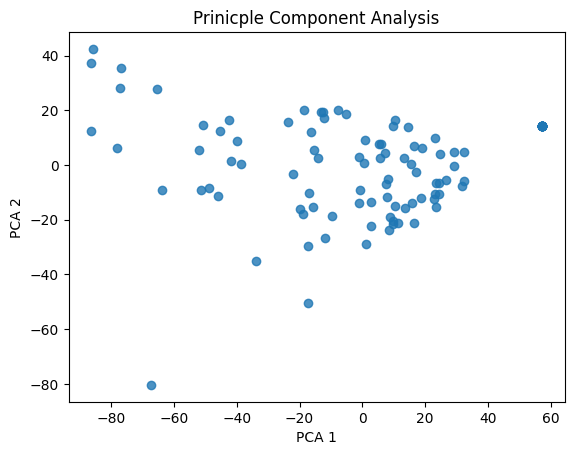

In [31]:
plt.scatter(guesser_reduced[:, 0], guesser_reduced[:, 1], alpha = 0.8)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Prinicple Component Analysis')
plt.show()

These new axes obtained upon using PCA gives us the direction in which most of the variance of the data is retained. They dont represent a specific attribute but in fact is a represenatation of the combined attributes to extract maximum information or variance from the data as possible.